# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import time
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

**Загрузим данные**

In [2]:
data = pd.read_csv('/datasets/autos.csv')

In [3]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


**Изучим информацию о данных**

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(


**Признаки:**

DateCrawled — дата скачивания анкеты из базы

VehicleType — тип автомобильного кузова

RegistrationYear — год регистрации автомобиля

Gearbox — тип коробки передач

Power — мощность (л. с.)

Model — модель автомобиля

Kilometer — пробег (км)

RegistrationMonth — месяц регистрации автомобиля

FuelType — тип топлива

Brand — марка автомобиля

NotRepaired — была машина в ремонте или нет

DateCreated — дата создания анкеты

NumberOfPictures — количество фотографий автомобиля

PostalCode — почтовый индекс владельца анкеты (пользователя)

LastSeen — дата последней активности пользователя

**Целевой признак:**

Price - цена

In [5]:
#меняем тип данных для признаков даты
list_date_columns = ['DateCrawled', 'DateCreated', 'LastSeen']
for clm in list_date_columns:
    data.loc[:, clm] = pd.to_datetime(data[clm].astype(str), format='%Y-%m-%d %H:%M:%S')

**Обработка пропусков**

In [6]:
null_features = []
for col in data.columns:
    if data[col].isna().values.any():
        null_features.append(col)

print("Признаки c пропущенными значениями:", *null_features)

Признаки c пропущенными значениями: VehicleType Gearbox Model FuelType NotRepaired


In [7]:
#Посмотрим количество пропущенных значений в выявленных признаках
count = []
percent = []
for col in null_features:
    count.append(data[col].isna().sum())
    percent.append((count[-1] / data.shape[0])*100)
    
null_values_df = pd.DataFrame(data={'count':count, 'percent':[p.round(2) for p in percent]}, index=null_features)
null_values_df.sort_values('count', ascending=False)

,count,percent
NotRepaired,71154,20.08
VehicleType,37490,10.58
FuelType,32895,9.28
Gearbox,19833,5.60
Model,19705,5.56


Проанализируем пропуски в признаке NotRepaired

In [8]:
pd.DataFrame({'no' : data['Price'].loc[data['NotRepaired'] == 'no'].describe().tolist(),
              'yes' : data['Price'].loc[data['NotRepaired'] == 'yes'].describe().tolist(),
              'nan' : data['Price'].loc[data['NotRepaired'].isna()].describe().tolist(),},
             index=['count','mean','std','min','25%','50%','75%','max'])

,no,yes,nan
count,247161.000000,36054.000000,71154.000000
mean,5296.811135,1916.039080,2626.419246
std,4723.939621,2670.474425,3360.612441
min,0.000000,0.000000,0.000000
25%,1600.000000,450.000000,500.000000
50%,3690.000000,900.000000,1390.000000
75%,7750.000000,2200.000000,3300.000000
max,20000.000000,20000.000000,20000.000000


Не хочется заменять пропуски NotRepaired на 'yes' или 'no', так как средние и медианные значения цены для пропусков отличаются от цен для категорий 'yes' или 'no'

Удалим пропуски в признаке NotRepaired. Но так как 20% данных это достаточно большой объём полезной информации, то сохраним копию данных и проверим потом на моделях с удалением пропусков и с созданием новой категории 'nan'.



In [9]:

data_drop_nan = data.copy()[~data['NotRepaired'].isna()]

In [10]:

data['NotRepaired'] = data['NotRepaired'].fillna('nan')

Попробуем удалить вообще признак VehicleType и сравним потом результаты с этим признаком и без него

In [11]:
data_drop_nan = data_drop_nan[~data_drop_nan['VehicleType'].isna()]

In [12]:
data['VehicleType'] = data['VehicleType'].fillna('nan')

In [13]:
#Посмотрим на ппризнак FuelType
data['FuelType'].value_counts()

petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

In [14]:
pd.DataFrame({'other' : data['Price'].loc[data['FuelType'] == 'other'].describe().tolist(),
              'nan' : data['Price'].loc[data['FuelType'].isna()].describe().tolist(),},
             index=['count','mean','std','min','25%','50%','75%','max'])


,other,nan
count,204.000000,32895.000000
mean,2312.029412,2340.639945
std,3455.271143,3274.042829
min,0.000000,0.000000
25%,140.000000,380.000000
50%,974.500000,1100.000000
75%,2862.500000,2850.000000
max,17500.000000,20000.000000


Распределение цены для FuelType со значением other и для пропусков довольно близки. Попробуем заменить пропуски в этом признаке на other

In [15]:
data['FuelType'] = data['FuelType'].fillna('other')

In [16]:
data_drop_nan['FuelType'] = data_drop_nan['FuelType'].fillna('other')

В остальных признаках заполним пропуски как есть

In [17]:
data['Gearbox'] = data['Gearbox'].fillna('nan')

In [18]:
data_drop_nan = data_drop_nan[~data_drop_nan['Gearbox'].isna()]

In [19]:
data['Model'] = data['Model'].fillna('nan')

In [20]:
data_drop_nan = data_drop_nan[~data_drop_nan['Model'].isna()]

Создали копию датафрейма в котором удалили все пропуски и признак VehicleType. В исходном датафрейме для пропусков создали отдельную категорию. В обоих датафреймах заменили пропуски в признаке FuelType на other.

Удалим ненужные признаки

In [21]:
data = data.drop(['DateCrawled', 'LastSeen'], axis=1)
data_drop_nan = data_drop_nan.drop(['DateCrawled', 'LastSeen'], axis=1)

Посмотрим влияет ли дата создания анкеты DateCreated на целевой признак Price

In [22]:
data['DateCreated_format'] = data['DateCreated'].apply(lambda x: x.strftime("%Y%m"))
pivot = data.pivot_table(index= 'DateCreated_format', values='Price', aggfunc='count')
data = data.drop(['DateCreated_format'], axis=1)
pivot.sort_values(by='Price', ascending=False)

,Price
DateCreated_format,
201603,296757
201604,57119
201602,397
201601,70
201511,9
201512,9
201509,3
201508,2
201403,1


Данные до 2016 года можно считать устаревшими, к тому же таких анкет очень мало. Удалим эти данные

In [23]:
data = data.loc[data['DateCreated'].dt.year >= 2016]
data_drop_nan = data_drop_nan.loc[data_drop_nan['DateCreated'].dt.year >= 2016]

Создадим новый категориальный признак - день недели подачи анкеты, зачастую в зависимости от него меняется цена. Проверим.

In [24]:
data.loc[:, 'DayOfWeek'] = data.loc[:, 'DateCreated'].dt.weekday
data_drop_nan.loc[:, 'DayOfWeek'] = data_drop_nan.loc[:, 'DateCreated'].dt.weekday


In [25]:
data[['DayOfWeek', 'Price']].groupby(by=['DayOfWeek']).mean()

,Price
DayOfWeek,
0,4411.029347
1,4273.600195
2,4318.393211
3,4336.419356
4,4445.776522
5,4504.363243
6,4616.046719


Наблюдается некоторая зависимость цены от дня подачи объявления. Оставим этот новый признак и удалим дату создания анкеты.

In [26]:
data = data.drop(['DateCreated'], axis=1)
data_drop_nan = data_drop_nan.drop(['DateCreated'], axis=1)

In [27]:
data['NumberOfPictures'].value_counts()

0    354343
Name: NumberOfPictures, dtype: int64

Фотографий нет, признак можем удалить

In [28]:
data = data.drop(['NumberOfPictures'], axis=1)
data_drop_nan = data_drop_nan.drop(['NumberOfPictures'], axis=1)

In [29]:
data['PostalCode'].value_counts()

10115    819
65428    613
66333    343
32257    317
44145    317
        ... 
21782      1
9517       1
29367      1
38325      1
82404      1
Name: PostalCode, Length: 8143, dtype: int64

8138 уникальных уникальных значений почтового индекса,и так как нам важна скороть обучения,  удалим их.

In [30]:
data = data.drop(['PostalCode'], axis=1)
data_drop_nan = data_drop_nan.drop(['PostalCode'], axis=1)

Посмотрим на распределение целевого признака - цены

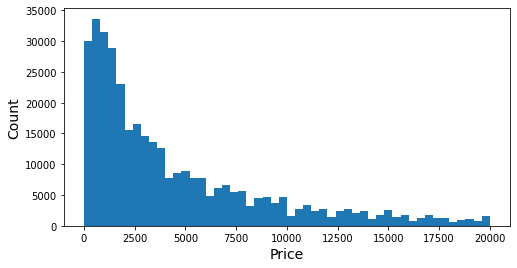

In [31]:
fig, ax = plt.subplots()
fig.set_size_inches(8,4)
ax.hist(data['Price'], bins=50)
ax.set_xlabel('Price', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
plt.show()

Нулевые значения цены является какой-то аномалией, скорее всего цена не была указана или указана неверно. Избавимся от таких значений, не будем прогнозировать нулевую цену.

In [32]:
data = data[~(data['Price'] == 0)]
data_drop_nan = data_drop_nan[~(data_drop_nan['Price'] == 0)]

Проверим так же значения пробега и мощности

In [33]:
data[data['Kilometer'] == 0].shape[0]

0

In [34]:
data[data['Power'] == 0].shape[0]

36358

Удалим нулевые данные, чтобы не портить модель

In [35]:
data = data[~(data['Power'] == 0)]
data_drop_nan = data_drop_nan[~(data_drop_nan['Power'] == 0)]

**Вывод**

В ходе подготовки данных сделано следующее:
- создали копию датафрейма в котором удалили все пропуски и признак VehicleType. В исходном датафрейме для пропусков создали отдельную категорию. В обоих датафреймах заменили пропуски в признаке FuelType на other.
- удалили признаки 'DateCrawled', 'LastSeen' и 'NumberOfPictures'
- взяли промежуток времени анкет с 2016 года (до этого удалили)
- добавили новый признак DayOfWeek (день недели подачи анкеты)
- удалили признак PostalCode для ускорения обучения
- удалили данные об автомобилях с нулевым значением цены и мощности

## Обучение моделей

Разделим датасет на обучающую, валидационную и тестовую выборку в пропорции 3:1:1

In [36]:
features = data.drop(['Price'], axis=1)
target = data['Price']

features_train, X, target_train, y = train_test_split(features, target, test_size=0.4, random_state=91)
features_valid, features_test, target_valid, target_test = train_test_split(X, y, test_size=0.5, random_state=91)

Проверим какой способ обработки пропусков оказался лучше: удалить пропуски или заменить пропуски новым значением 'nan'

In [37]:
cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

In [38]:
%%time

model = CatBoostRegressor(loss_function='RMSE', iterations=100, verbose=20, thread_count=-1, random_seed=91)

list_data = [data, data_drop_nan]
list_rmse = []

for df in list_data:
    features = df.drop(['Price'], axis=1)
    target = df['Price']

    features_train, X, target_train, y = train_test_split(features, target, test_size=0.4, random_state=91)
    features_valid, features_test, target_valid, target_test = train_test_split(X, y, test_size=0.5, random_state=91)

    model.fit(features_train, target_train, cat_features=cat_features)
    pred_valid = model.predict(features_valid)
    list_rmse.append(mean_squared_error(target_valid, pred_valid, squared=False))

print()
print(f'RMSE при замене пропусков:   {list_rmse[0]}')
print(f'RMSE при удалении пропусков: {list_rmse[1]}')

Learning rate set to 0.5
0:	learn: 3272.4475383	total: 142ms	remaining: 14s
20:	learn: 1826.4304528	total: 1.6s	remaining: 6.04s
40:	learn: 1743.0439704	total: 3.01s	remaining: 4.34s
60:	learn: 1702.4862374	total: 4.43s	remaining: 2.83s
80:	learn: 1673.2618153	total: 5.81s	remaining: 1.36s
99:	learn: 1651.3056301	total: 7.12s	remaining: 0us
Learning rate set to 0.5
0:	learn: 3267.7775406	total: 58.3ms	remaining: 5.77s
20:	learn: 1776.8525140	total: 961ms	remaining: 3.61s
40:	learn: 1689.5869336	total: 1.85s	remaining: 2.66s
60:	learn: 1641.9399897	total: 2.7s	remaining: 1.73s
80:	learn: 1607.3822152	total: 3.57s	remaining: 837ms
99:	learn: 1586.8054945	total: 4.41s	remaining: 0us

RMSE при замене пропусков:   1706.1657144036283
RMSE при удалении пропусков: 1690.0372798175615
CPU times: user 12.3 s, sys: 176 ms, total: 12.5 s
Wall time: 13.7 s


Разница не очень большая в пользу данных,  в которых удалены пропуски, но все же лучше оставить пропуск как отдельную категорию.

**Desicion Tree**

In [39]:
features_train_encoded = features_train.copy()
features_valid_encoded = features_valid.copy()
features_train_encoded[cat_features] = OrdinalEncoder().fit_transform(features_train_encoded[cat_features])
features_valid_encoded[cat_features] = OrdinalEncoder().fit_transform(features_valid_encoded[cat_features])

In [40]:
tree = DecisionTreeRegressor(max_depth=10).fit(features_train_encoded, target_train)
pred_valid = tree.predict(features_valid_encoded)
print(f'RMSE of Desicion Tree: {mean_squared_error(target_valid, pred_valid, squared=False)}')

RMSE of Desicion Tree: 2003.074651591403


**CatBoost**

In [41]:
%%time

model = CatBoostRegressor(cat_features=cat_features,
                          loss_function='RMSE',
                          verbose=50,
                          thread_count=-1,
                          random_seed=91)

grid = {'learning_rate': [0.1, 0.5],
        'depth': [10, 12],
        'l2_leaf_reg': [3, 7],
        'iterations' : [50, 200]}

grid_search_result = model.grid_search(grid, 
                                       X=features_train, 
                                       y=target_train,
                                       plot=True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 6442.6766062	test: 6501.2710566	best: 6501.2710566 (0)	total: 70.1ms	remaining: 3.43s
49:	learn: 1710.0030858	test: 1723.7928306	best: 1723.7928306 (49)	total: 3.24s	remaining: 0us

bestTest = 1723.792831
bestIteration = 49

0:	loss: 1723.7928306	best: 1723.7928306 (0)	total: 3.88s	remaining: 58.2s
0:	learn: 4157.0518462	test: 4180.3673894	best: 4180.3673894 (0)	total: 70.5ms	remaining: 3.46s
49:	learn: 1493.1045076	test: 1623.6173026	best: 1623.6173026 (49)	total: 3.33s	remaining: 0us

bestTest = 1623.617303
bestIteration = 49

1:	loss: 1623.6173026	best: 1623.6173026 (1)	total: 7.23s	remaining: 50.6s
0:	learn: 6447.0098367	test: 6505.4566902	best: 6505.4566902 (0)	total: 71.8ms	remaining: 3.52s
49:	learn: 1720.3113023	test: 1724.8456396	best: 1724.8456396 (49)	total: 3.31s	remaining: 0us

bestTest = 1724.84564
bestIteration = 49

2:	loss: 1724.8456396	best: 1623.6173026 (1)	total: 10.6s	remaining: 45.8s
0:	learn: 4176.8009099	test: 4199.1927818	best: 4199.1927818 (0)	total:

In [42]:
grid_search_result['params']

{'depth': 12, 'l2_leaf_reg': 3, 'iterations': 200, 'learning_rate': 0.1}

In [43]:
%%time

model = CatBoostRegressor(cat_features=cat_features,
                          loss_function='RMSE',
                          **grid_search_result['params'],
                          verbose=20,
                          thread_count=-1,
                          random_seed=91)
model.fit(features_train, target_train)
pred_valid = model.predict(features_valid)
print(f'RMSE: {mean_squared_error(target_valid, pred_valid, squared=False)}')

0:	learn: 4370.3690791	total: 360ms	remaining: 1m 11s
20:	learn: 1863.3205931	total: 6.58s	remaining: 56.1s
40:	learn: 1636.4315132	total: 12.4s	remaining: 48s
60:	learn: 1575.6179461	total: 18.1s	remaining: 41.2s
80:	learn: 1535.7985783	total: 24.3s	remaining: 35.6s
100:	learn: 1503.6748004	total: 30s	remaining: 29.4s
120:	learn: 1476.9171863	total: 36.2s	remaining: 23.7s
140:	learn: 1452.8910223	total: 42.7s	remaining: 17.9s
160:	learn: 1432.8683887	total: 49.5s	remaining: 12s
180:	learn: 1407.4601200	total: 56.3s	remaining: 5.91s
199:	learn: 1386.9130457	total: 1m 2s	remaining: 0us
RMSE: 1552.5055052764674
CPU times: user 1min 2s, sys: 219 ms, total: 1min 3s
Wall time: 1min 3s


**LightGBM**

In [44]:
lgb_model = LGBMRegressor(learning_rate=0.05, max_depth=12, num_leaves=100,
                            random_state=91,
                            n_jobs=-1)
lgb_model.fit(features_train_encoded, target_train)
pred_valid = lgb_model.predict(features_valid_encoded)


In [45]:
print(f'RMSE: {mean_squared_error(target_valid, pred_valid, squared=False)}')

RMSE: 1692.0954860376758


По оценке RMSE градиентный бустинг оказывается лучше Linear Regression и Desicion Tree. Посмотрим на анализ скорости работы и качества моделей.

## Анализ моделей

Сравним библиотеки CatBoost и LightGBM


In [46]:
list_quality = []
list_predict = []
list_train   = []

In [47]:
start = time.time()

model = CatBoostRegressor(cat_features=cat_features,
                          loss_function='RMSE',
                          **grid_search_result['params'],
                          silent=True,
                          thread_count=-1,
                          random_seed=91)
model.fit(features_train, target_train)

list_train.append(time.time() - start)

In [48]:
start = time.time()

lgb_model = LGBMRegressor(learning_rate=0.05, max_depth=12, num_leaves=100,
                            random_state=91,
                            n_jobs=-1)
lgb_model.fit(features_train_encoded, target_train)

list_train.append(time.time() - start)

In [49]:
features_test_encoded = features_test.copy()
features_test_encoded[cat_features] = OrdinalEncoder().fit_transform(features_test_encoded[cat_features])

In [50]:
start = time.time()

pred_catboost = model.predict(features_test)

list_predict.append(time.time() - start)

In [51]:
start = time.time()

pred_lgb = lgb_model.predict(features_test_encoded)

list_predict.append(time.time() - start)

In [52]:
list_quality.append(mean_squared_error(target_test, pred_catboost, squared=False))

In [53]:
list_quality.append(mean_squared_error(target_test, pred_lgb, squared=False))

In [54]:
pd.DataFrame([list_train, list_predict, list_quality],
             index=['Train Time', 'Predict Time', 'RMSE'],
             columns=['CatBoost', 'LightGBM'])

,CatBoost,LightGBM
Train Time,63.670661,70.902987
Predict Time,0.200641,0.472510
RMSE,1558.066796,1691.684654


**Вывод**


До обучения моделей были обработаны пропущенные значения и сравнены способы обработки пропущенных значений.
Были выявлены и удалены некоторые аномалии в данных.

Было проведено сравнение  Desicion Tree и библиотек градиентного бустинга CatBoost и LightGBM

Были подобраны наилучшие параметры для CatBoostRegressor и LGBMRegressor

Регрессия с помощью библиотек градиентного бустинга позволяет улучшить результат прогноза по сравнению с более простыми алгоритмами, но обучаются они сравнительно дольше.

Сравнение библиотеки CatBoost и LightGBM показало, что CatBoost  точнее и быстрее.